In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import pandas as pd
import seaborn as sns

import cv2
import skvideo.io
import imageio
import pytube

import multiprocessing as mp
import os
import time
import csv
import re
import humanize
from tqdm import tqdm

from skimage.measure import compare_mse, compare_ssim, compare_nrmse
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import hamming
from imageai.Detection import ObjectDetection
from imageai.Detection import VideoObjectDetection

Using TensorFlow backend.


In [3]:
def get_FPS(video_loc):
    """
    A function to compute the frame per second of the video
    
    Parameters
    ----------
    video_loc: str
        Location of the input video
        
    Returns
    -------
        A float number that is the FPS of the given video
    """
    
    video = cv2.VideoCapture(video_loc)
    fps = video.get(cv2.CAP_PROP_FPS)
    return fps

In [4]:
data_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'

In [5]:
train_video = os.path.join(data_path, 'speed-challenge-test.webm')

In [6]:
get_FPS(train_video)

25.0

In [7]:
## The pre-trained network model (https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/README.md)
model = 'resnet50_coco_best_v2.0.1.h5'
detector = VideoObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath(os.path.join('/home/idies/workspace/Storage/Cong/persistent/video', model))
detector.loadModel()

In [8]:
## Generate a video with all detected objects directly
video_path = detector.detectObjectsFromVideo(input_file_path=train_video,
                                             output_file_path='/home/idies/workspace/Temporary/Cong/scratch/detected', 
                                             frames_per_second=25, log_progress=True)

Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  

Processing Frame :  347
Processing Frame :  348
Processing Frame :  349
Processing Frame :  350
Processing Frame :  351
Processing Frame :  352
Processing Frame :  353
Processing Frame :  354
Processing Frame :  355
Processing Frame :  356
Processing Frame :  357
Processing Frame :  358
Processing Frame :  359
Processing Frame :  360
Processing Frame :  361
Processing Frame :  362
Processing Frame :  363
Processing Frame :  364
Processing Frame :  365
Processing Frame :  366
Processing Frame :  367
Processing Frame :  368
Processing Frame :  369
Processing Frame :  370
Processing Frame :  371
Processing Frame :  372
Processing Frame :  373
Processing Frame :  374
Processing Frame :  375
Processing Frame :  376
Processing Frame :  377
Processing Frame :  378
Processing Frame :  379
Processing Frame :  380
Processing Frame :  381
Processing Frame :  382
Processing Frame :  383
Processing Frame :  384
Processing Frame :  385
Processing Frame :  386
Processing Frame :  387
Processing Frame

ValueError: An error occured. It may be that your input video is invalid. Ensure you specified a proper string value for 'output_file_path' is 'save_detected_video' is not False. Also ensure your per_frame, per_second, per_minute or video_complete_analysis function is properly configured to receive the right parameters. 

In [ ]:
# def detect_object(img, save_path, model='resnet50_coco_best_v2.0.1.h5', minimum_prob=50):
#     detector = ObjectDetection()
#     detector.setModelTypeAsRetinaNet()
#     detector.setModelPath(os.path.join('/home/idies/workspace/Storage/Cong/persistent/video', model))
#     detector.loadModel()
#     detections, objects_path = detector.detectObjectsFromImage(input_image=img, input_type='array', output_image_path=save_path, minimum_percentage_probability=minimum_prob, extract_detected_objects=True)
#     return detections, objects_path

In [ ]:
# def get_carcoords(start):
#     results_dict = {}
    
#     for i in range(start, start+length):
#         img = imread(img_df['img_path'][i])
#         detections, objects_path = detect_object(img, os.path.join(save_path, str(i)))
#         results_dict[i] = [img_df['img_path'][i], img_df['img_index'][i], detections, objects_path]
        
#     return results_dict

In [ ]:
# result_path = '/home/idies/workspace/Storage/Cong/persistent/video/result/detected'

In [ ]:
# img_df = pd.read_csv(os.path.join(data_path, 'train-speed-challenge-test_raw.csv'))
# length = 10

# pool = mp.Pool(processes=5)
# results = [pool.apply(get_carcoords, args=(start,)) for start in range(100, 150, length)]

# np.save(os.path.join(result_path, 'objects1.npy'), results)

In [ ]:
# files = os.listdir('./result/detected')
# objects = {}

In [ ]:
# for i in range(len(files)):
#     temp = np.load(os.path.join('./result/detected', files[i])).item()
#     objects[i+1] = temp[i+1][1]

In [ ]:
# np.save('./result/objects.npy', objects)

In [9]:
## Basic analysis frame by frame
objects = np.load('./result/objects.npy').item()

In [10]:
dat = pd.DataFrame.from_dict(objects, orient='index')

In [11]:
dat.columns

Index(['car', 'truck', 'bus', 'person', 'stop sign', 'train', 'kite', 'tv',
       'horse', 'motorcycle', 'bicycle', 'traffic light', 'suitcase',
       'backpack', 'sink', 'broccoli', 'boat', 'potted plant', 'bird',
       'airplane', 'bench', 'bottle', 'cow', 'frisbee', 'umbrella'],
      dtype='object')

In [12]:
dat_dict = {}
objs = ['person', 'car', 'truck', 'bus', 'motorcycle', 'bicycle', 'stop sign', 'traffic light']

In [13]:
for i in range(len(objects)):
    dat_dict[i+1] = {'frame': i}
    for obj in objs:
        if objects[i+1].get(obj) is None:
            dat_dict[i+1][obj] = 0
        else:
            dat_dict[i+1][obj] = objects[i+1].get(obj)

In [14]:
dat_df = pd.DataFrame.from_dict(dat_dict, orient='index')
dat_df.head()

,frame,person,car,truck,bus,motorcycle,bicycle,stop sign,traffic light
1,0,0,4,0,0,0,0,0,0
2,1,0,4,0,0,0,0,0,0
3,2,0,4,0,0,0,0,0,0
4,3,0,4,0,0,0,0,0,0
5,4,0,4,0,0,0,0,0,0


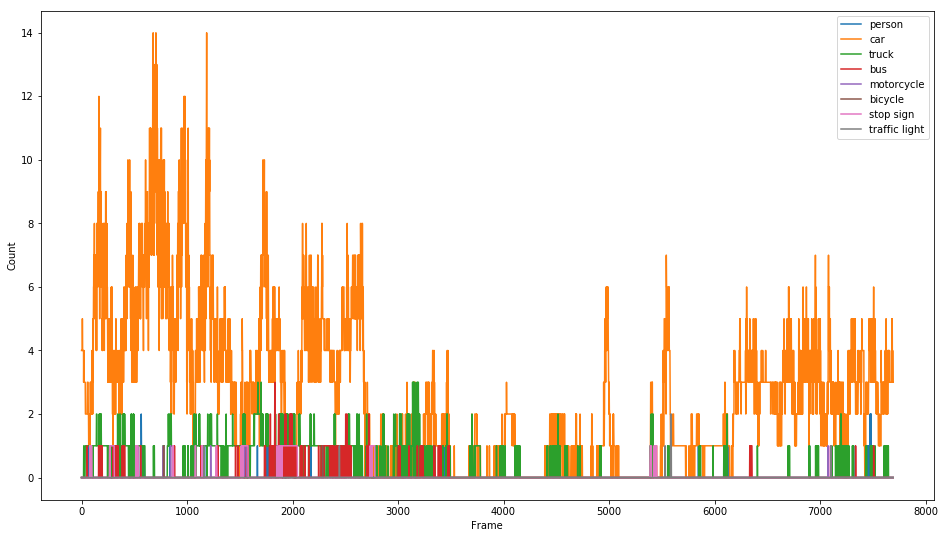

In [15]:
dat_df.set_index('frame').plot(figsize=(16,9));
xlabel('Frame');
ylabel('Count');

In [16]:
dat_df.columns

Index(['frame', 'person', 'car', 'truck', 'bus', 'motorcycle', 'bicycle',
       'stop sign', 'traffic light'],
      dtype='object')

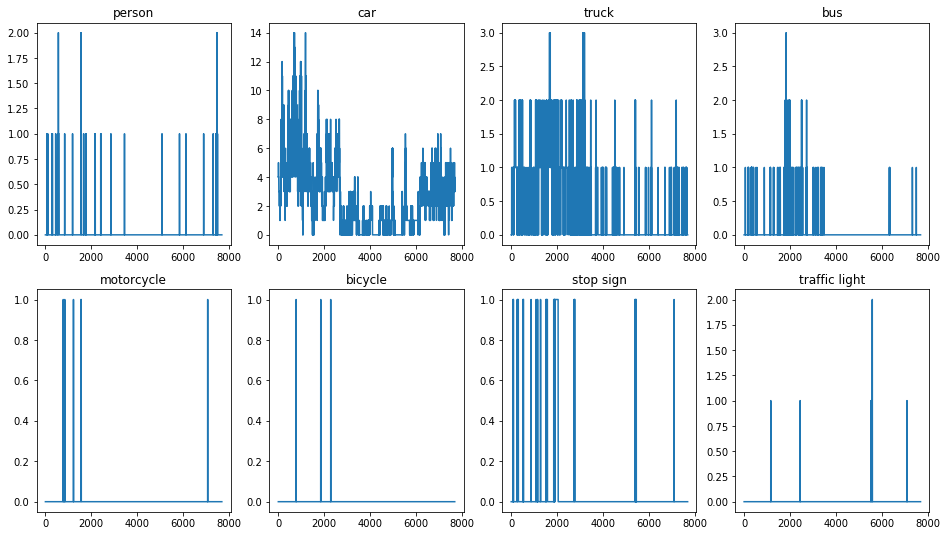

In [17]:
figure(figsize=(16,9));
subplot(2, 4, 1);
title('person');
plot(dat_df.frame, dat_df.person);
subplot(2, 4, 2);
title('car');
plot(dat_df.frame, dat_df.car);
subplot(2, 4, 3);
title('truck');
plot(dat_df.frame, dat_df.truck);
subplot(2, 4, 4);
title('bus');
plot(dat_df.frame, dat_df.bus);
subplot(2, 4, 5);
title('motorcycle');
plot(dat_df.frame, dat_df.motorcycle);
subplot(2, 4, 6);
title('bicycle');
plot(dat_df.frame, dat_df.bicycle);
subplot(2, 4, 7);
title('stop sign');
plot(dat_df.frame, dat_df['stop sign']);
subplot(2, 4, 8);
title('traffic light');
plot(dat_df.frame, dat_df['traffic light']);

In [18]:
dat_seconds_dict = {}

In [19]:
for i in range(1, 5000, 25):
    dat_seconds_dict[i] = {'person': np.mean(dat_df['person'][(i):(i+25)]), 
                           'car': np.mean(dat_df['car'][(i):(i+25)]), 
                           'truck': np.mean(dat_df['truck'][(i):(i+25)]), 
                           'bus': np.mean(dat_df['bus'][(i):(i+25)]), 
                           'motorcycle': np.mean(dat_df['motorcycle'][(i):(i+25)]), 
                           'bicycle': np.mean(dat_df['bicycle'][(i):(i+25)]), 
                           'stop sign': np.mean(dat_df['stop sign'][(i):(i+25)]), 
                           'traffic light': np.mean(dat_df['traffic light'][(i):(i+25)])}

In [20]:
dat_seconds_df = pd.DataFrame.from_dict(dat_seconds_dict, orient='index')
dat_seconds_df.index = np.arange(1, 201)
dat_seconds_df.head()

,person,car,truck,bus,motorcycle,bicycle,stop sign,traffic light
1,0.00,3.88,0.12,0.00,0.0,0.0,0.00,0.0
2,0.00,2.40,0.68,0.00,0.0,0.0,0.00,0.0
3,0.04,2.04,1.00,0.04,0.0,0.0,0.00,0.0
4,0.36,2.24,0.88,0.00,0.0,0.0,0.44,0.0
5,0.08,5.00,0.88,0.00,0.0,0.0,0.00,0.0


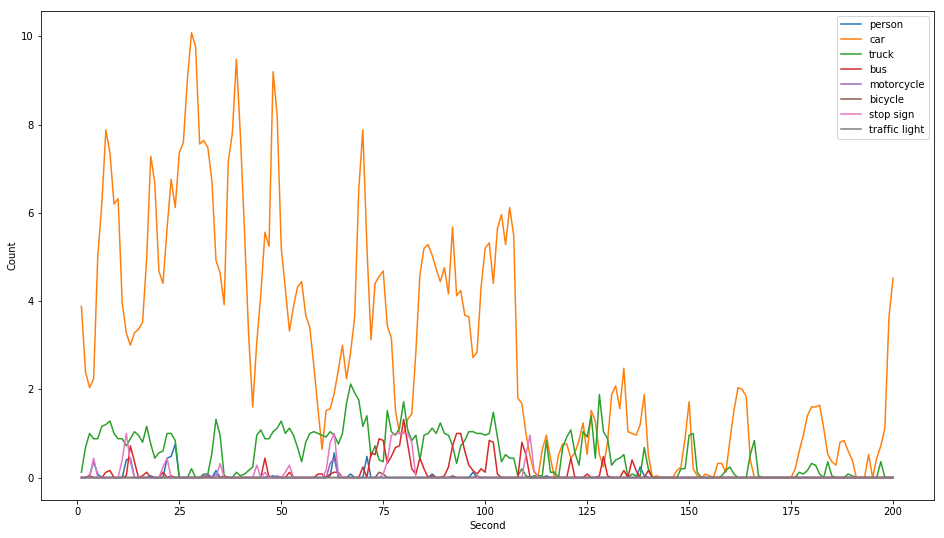

In [21]:
dat_seconds_df.plot(figsize=(16,9));
xlabel('Second');
ylabel('Count');